# Data Preparation
## Merge Datasets

In [384]:
# import libraries and adjust settings
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set pyplot style
plt.style.use('fivethirtyeight') 

# Render our plots inline
%matplotlib inline

# set figure size
plt.rcParams['figure.figsize'] = (15, 8)

# load datasets
inPath = r'data/'
df_CPI = pd.read_csv(inPath+'preprocessed/exp_CountriesCPI.csv')
df_COVID = pd.read_csv(inPath+'preprocessed/exp_keyCountriesCovid.csv')
df_UNEMPLOYMENT = pd.read_csv(inPath+'preprocessed/exp_keyCountriesUnemployment.csv')
df_GDP = pd.read_csv(inPath+'preprocessed/exp_worldGDP.csv')
df_REF = pd.read_csv(inPath+'covid/reference.csv')


### Previewing imported datasets

In [385]:
# Note: Just Germany
df_CPI.head()

,Year,Months,import_prices_index,Change on previous month in(%),Change on previous year's month in(%),export_prices_index,Change on previous month in(%).1,Change on previous year's month in(%).1,Consumer price index,Change on previous year's month in(%).2,Change on previous month in(%).2
0,2019,January,102.2,-0.2,0.8,102.2,0.1,1.1,103.4,1.4,-0.8
1,2019,February,102.5,0.3,1.6,102.3,0.1,1.3,103.8,1.5,0.4
2,2019,March,102.5,-,1.7,102.4,0.1,1.3,104.2,1.3,0.4
3,2019,April,102.8,0.3,1.4,102.6,0.2,1.3,105.2,2,1
4,2019,May,102.7,-0.1,-0.2,102.5,-0.1,0.7,105.4,1.4,0.2


In [386]:
df_COVID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    72 non-null     int64  
 1   location                72 non-null     object 
 2   month                   72 non-null     int64  
 3   Monthly_new_cases       72 non-null     float64
 4   Percentage Growth Rate  71 non-null     float64
 5   PG_Rate                 71 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 3.5+ KB


In [387]:
df_UNEMPLOYMENT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Month                      72 non-null     int64  
 1   Country                    72 non-null     object 
 2   Unemployment_Rate_Percent  67 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ KB


In [388]:
df_GDP.head()

,TIME,GEO,GDP
0,2010Q3,European Union - 27 countries (from 2020),2737806.5
1,2010Q3,European Union - 28 countries (2013-2020),3219688.1
2,2010Q3,Euro area - 19 countries (from 2015),2372179.6
3,2010Q3,Belgium,88635.0
4,2010Q3,Bulgaria,10342.2


### Merge: covid <--> unemployment

In [389]:
# tables are joined on date and location, therefore check location description first
print (df_COVID.location.unique())
print (df_UNEMPLOYMENT.Country.unique())

# write out abbreviations UK and US in their full length within df_UNEMPLOYMENT
df_UNEMPLOYMENT['Country'] = df_UNEMPLOYMENT['Country'].replace({'USA':'United States'})
df_UNEMPLOYMENT['Country'] = df_UNEMPLOYMENT['Country'].replace({'UK':'United Kingdom'})

# create new dataframe which is supposed to hold merged data
df_MERGED = df_COVID
df_MERGED['Unemployment_Rate_Percent'] = np.NaN

# set values of new dataframes's column Unemployment_Rate_Percent 
# joining where year, location and month match
for srcIndex, srcRow in df_MERGED.iterrows():
    srcLocation = srcRow['location']
    srcMonth = srcRow['month']
    for tgIndex, tgRow in df_UNEMPLOYMENT.iterrows():
        if (srcLocation == tgRow['Country'] and srcMonth == tgRow['Month']):
           df_MERGED.loc[srcIndex,'Unemployment_Rate_Percent'] = tgRow['Unemployment_Rate_Percent']
df_MERGED



['China' 'Germany' 'India' 'Italy' 'United Kingdom' 'United States']
['Germany' 'India' 'China' 'Italy' 'USA' 'UK']


,year,location,month,Monthly_new_cases,Percentage Growth Rate,PG_Rate,Unemployment_Rate_Percent
0,2020,China,1,9254.0,NaN,NaN,5.3
1,2020,China,2,69554.0,651.610115,651.610115,6.2
2,2020,China,3,2923.0,-95.797510,-95.797510,5.9
3,2020,China,4,1677.0,-42.627438,-42.627438,6.0
4,2020,China,5,190.0,-88.670244,-88.670244,5.9
...,...,...,...,...,...,...,...
67,2020,United States,8,1458899.0,-24.200596,-24.200596,7.8
68,2020,United States,9,1206247.0,-17.317991,-17.317991,6.9
69,2020,United States,10,1926777.0,59.733206,59.733206,6.7
70,2020,United States,11,4496140.0,133.350305,133.350305,6.7


### Merge: covid, umemployment <--> GDP

In [390]:
# tables are joined on location and time
print (df_MERGED.location.unique())
print (df_GDP.GEO.unique())

# 1st step: remove everything in brackets in column GEO and strip whitespaces
df_GDP.GEO = df_GDP.GEO.replace(to_replace=r'\((.*?)\)',value='',regex=True)

# 2nd step: reduce df_GDP to year 2020
df_GDP = df_GDP[df_GDP.TIME.str.contains(r'(2020)')]

# 3rd step: create subselection with key-countries
df_GDP = df_GDP[df_GDP.GEO.str.contains(r'(China|Germany|India|Italy|United Kingdom|United States)')]
df_GDP.GEO = df_GDP.GEO.str.rstrip() # remove whitesoace after Germany
df_GDP.GEO = df_GDP.GEO.replace(to_replace='China including Hong Kong',value='China')

# 4th step: add new column which is supposed to hold GDP value
df_MERGED['GDP'] = ''

# 5th step: set values of new column GDP
# Problem: GDP Value exists only quarterly -> Solution: fill every month with corresponding value of quarter
Q1 = [1,2,3]
Q2 = [4,5,6]
Q3 = [7,8,9] # remark: no Data for 2020Q4

for srcIndex, srcRow in df_MERGED.iterrows():
    srcLocation = srcRow['location']
    srcMonth = srcRow['month']
    for tgIndex, tgRow in df_GDP.iterrows():
        if (srcLocation == tgRow['GEO'] and srcMonth in Q1 and tgRow['TIME']=='2020Q1'):
           df_MERGED.loc[srcIndex,'GDP'] = tgRow.GDP
        elif (srcLocation == tgRow['GEO'] and srcMonth in Q2 and tgRow['TIME']=='2020Q2'):
           df_MERGED.loc[srcIndex,'GDP'] = tgRow.GDP
        elif (srcLocation == tgRow['GEO'] and srcMonth in Q3 and tgRow['TIME']=='2020Q3'):
           df_MERGED.loc[srcIndex,'GDP'] = tgRow.GDP

# 6th step: convert GDP to numeric
df_MERGED.GDP = df_MERGED.GDP.apply(pd.to_numeric)

# add GDP per capita for easier comparison 
# GDP / Population
df_MERGED['GDP per capita'] = np.NaN

for srcIndex, srcRow in df_MERGED.iterrows():
    if (srcRow['location'] == 'United States'):
        pop = df_REF.loc[df_REF['Combined_Key']=='US'].Population.values[0]
        gdp = srcRow.GDP
        df_MERGED.loc[srcIndex,'GDP per capita'] = gdp / pop
    else:
        pop = df_REF.loc[df_REF['Combined_Key']==srcRow['location']].Population.values[0]
        gdp = srcRow.GDP 
        df_MERGED.loc[srcIndex,'GDP per capita'] = gdp / pop

df_MERGED



['China' 'Germany' 'India' 'Italy' 'United Kingdom' 'United States']
['European Union - 27 countries (from 2020)'
 'European Union - 28 countries (2013-2020)'
 'Euro area - 19 countries  (from 2015)' 'Belgium' 'Bulgaria' 'Czechia'
 'Denmark' 'Germany (until 1990 former territory of the FRG)' 'Estonia'
 'Ireland' 'Greece' 'Spain' 'France' 'Croatia' 'Italy' 'Cyprus' 'Latvia'
 'Lithuania' 'Luxembourg' 'Hungary' 'Malta' 'Netherlands' 'Austria'
 'Poland' 'Portugal' 'Romania' 'Slovenia' 'Slovakia' 'Finland' 'Sweden'
 'United Kingdom' 'Iceland' 'Norway' 'Switzerland' 'Montenegro'
 'North Macedonia' 'Albania' 'Serbia' 'Turkey' 'Belarus'
 'Bosnia and Herzegovina'
 'Kosovo (under United Nations Security Council Resolution 1244/99)'
 'Moldova' 'Russia' 'Ukraine' 'Mauritius' 'Rwanda' 'Seychelles' 'Egypt'
 'Morocco' 'Botswana' 'Namibia' 'South Africa' 'Cabo Verde' 'Nigeria'
 'Canada' 'United States' 'Dominican Republic' 'Jamaica' 'Costa Rica'
 'El Salvador' 'Guatemala' 'Honduras' 'Mexico' 'Nicaragu

,year,location,month,Monthly_new_cases,Percentage Growth Rate,PG_Rate,Unemployment_Rate_Percent,GDP,GDP per capita
0,2020,China,1,9254.0,NaN,NaN,5.3,2683407.4,0.001910
1,2020,China,2,69554.0,651.610115,651.610115,6.2,2683407.4,0.001910
2,2020,China,3,2923.0,-95.797510,-95.797510,5.9,2683407.4,0.001910
3,2020,China,4,1677.0,-42.627438,-42.627438,6.0,3203254.4,0.002280
4,2020,China,5,190.0,-88.670244,-88.670244,5.9,3203254.4,0.002280
...,...,...,...,...,...,...,...,...,...
67,2020,United States,8,1458899.0,-24.200596,-24.200596,7.8,4554429.8,0.013824
68,2020,United States,9,1206247.0,-17.317991,-17.317991,6.9,4554429.8,0.013824
69,2020,United States,10,1926777.0,59.733206,59.733206,6.7,NaN,NaN
70,2020,United States,11,4496140.0,133.350305,133.350305,6.7,NaN,NaN


## Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       72 non-null     int64  
 1   location                   72 non-null     object 
 2   month                      72 non-null     int64  
 3   Monthly_new_cases          72 non-null     float64
 4   Percentage Growth Rate     71 non-null     float64
 5   PG_Rate                    71 non-null     float64
 6   Unemployment_Rate_Percent  67 non-null     float64
 7   GDP                        54 non-null     float64
 8   GDP per capita             54 non-null     float64
dtypes: float64(6), int64(2), object(1)
memory usage: 5.2+ KB


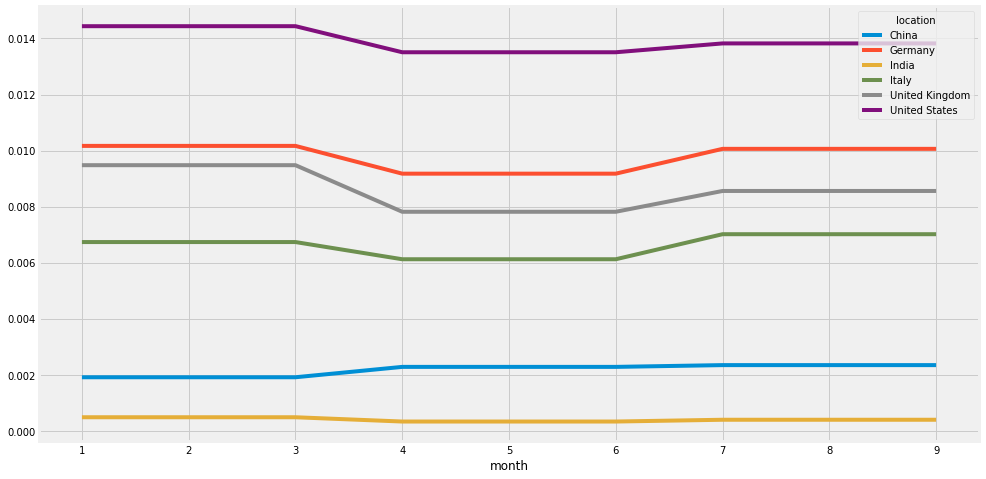

location,China,Germany,India,Italy,United Kingdom,United States
month,,,,,,
1,5.3,3.4,7.22,9.6,3.9,3.5
2,6.2,3.6,7.76,9.4,3.9,4.4
3,5.9,3.8,8.75,8.5,3.9,14.8
4,6.0,4.0,23.52,7.4,3.9,13.3
5,5.9,4.2,21.73,8.7,3.8,11.1
6,5.7,4.3,10.18,9.3,4.0,10.2
7,5.7,4.4,7.40,9.8,4.4,8.4
8,5.6,4.5,8.35,9.7,4.7,7.8
9,5.4,4.5,6.67,9.5,4.9,6.9


In [391]:
# 1. get data
# 2. plt.plot(x,y, color='', linestyle='', marker='',label='label)
# 3. set labels: plt.xlabel('') and plt.ylabel('')
# 4. set title: plt.title('')
# 5. set legend: plt.legend() -> uses labels
# 6. plt.grid(True)
# 7. plt.savefig('filename.png')
# 8. plt.show()
df_MERGED.info()
axis_x = (df_MERGED.month.unique())
pivGDP = df_MERGED.pivot(index='month',columns='location',values='GDP')
pivGDPpCap = df_MERGED.pivot(index='month',columns='location',values='GDP per capita')
pivUnemployment = df_MERGED.pivot(index='month',columns='location',values='Unemployment_Rate_Percent')
pivCovid = df_MERGED.pivot(index='month',columns='location',values='Monthly_new_cases')

pivGDPpCap.plot()
plt.show()
pivUnemployment


# Export as csv

In [392]:
outPath = r'../project/data/preprocessed/'
df_MERGED.to_csv(path+'exp_mergedData.csv', sep=',', index=False)